In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA
import plotly.graph_objs as go
import plotly.colors as colors
from linear_sca import *
import wandb

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [3]:
def pre_processing(X,
               soft_normalize = 'churchland',
               soft_normalize_value = 5,
               center=True,
               pca=True,
               num_pcs=30):
        
        K, N, T = X.shape
        if soft_normalize == 'churchland': 
            """ soft-normalized to approximately unity firing rate range (divided by a normalization factor equal 
            to the firing rate range + 5 spikes per s) (Elsayed, 2017)"""
            range = jnp.max(X, axis=(0,2), keepdims=True) - jnp.min(X, axis=(0,2), keepdims=True)
            X = X / (range + soft_normalize_value)
        else:
            norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
            X = X / norm_const
                
        if center:
            condition_mean = jnp.mean(X, axis=0, keepdims=True)
            X = X - condition_mean

        pca_variance_captured = None

        if pca:
            X_reshaped = X.swapaxes(1,2).reshape(-1,N)                      #np.concatenate(X.swapaxes(1,2))
            pca = PCA(num_pcs)
            X = pca.fit_transform(X_reshaped)
            X = X.reshape(K, T, num_pcs).swapaxes(1,2)
            pca_variance_captured = pca.explained_variance_

        return jnp.array(X), pca_variance_captured

X, _ = pre_processing(X, soft_normalize='max')

In [42]:
def single_pair_S(X, id_1, id_2, operator):
    XX = jnp.einsum('ij,kj->ik', X[id_1, :, :], X[id_2, :, :])          #(N,N)
    XX_product = jnp.einsum('ij,lm->im', XX, XX)                        #(N,N)
    XX_product = XX @ XX


    if operator == 'minus':
        return jnp.trace(XX)**2 - jnp.trace(XX_product)
    
    elif operator == 'plus':
        return jnp.trace(XX)**2 + jnp.trace(XX_product)


def compute_S(X, seed=42, iterations=1000):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    keys = random.split(key, num=iterations)

    S_list = []
    for i in range(iterations):
        num_pairs = 100  
        indices = random.randint(keys[i], shape=(num_pairs*2,), minval=0, maxval=N)
        index_pairs = indices.reshape((num_pairs, 2))

        batched_numerator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'minus')
        batched_denominator = vmap(single_pair_S, in_axes=(None, 0, 0, None))(X, index_pairs[:, 0], index_pairs[:, 1], 'plus') 
        S_list.append( jnp.sum(batched_numerator) / jnp.sum(batched_denominator) )
    return S_list

S_list = compute_S(X)
print(np.mean(S_list))

0.52820456


In [16]:
                   
def single_pair_loss(U_tilde, X, id_1, id_2, operator = 'minus'):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    #YY_product = jnp.einsum('ij,lm->im', YY, YY)                       #(d,d)
    YY_product = YY @ YY                                                #(d,d)


    if operator == 'minus':
        return jnp.trace(YY)**2 - jnp.trace(YY_product)
    
    elif operator == 'plus':
        return jnp.trace(YY)**2 + jnp.trace(YY_product)
    
def loss(params, X, key, s_learn, normalized = False):  
    K, N, T = X.shape

    if s_learn:
        U = params['U']
        s = params['s'] 

        s_normalized = jnp.sqrt(N) * (s**2) /  jnp.linalg.norm(s**2)
        X = s_normalized[None, :, None] * X
    else:
        U = params
    
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 1000  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)
    
    if normalized == False:
        S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
        return -S
    else: 
        batched_normalizer = vmap(single_pair_loss, in_axes=(None, None, 0, 0, None))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1], 'plus')
        return jnp.sum(batched_loss) / jnp.sum(batched_normalizer)

def update(params, X, optimizer, opt_state, key, s_learn):
    grad_ = grad(loss)(params,X,key, s_learn)
  
    updates, opt_state_updated = optimizer.update(grad_, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize(X, s_learn=False, iterations=10000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape

    key = random.PRNGKey(seed)
    
    U = random.normal(key, (N, d))
    s = random.normal(key, (N,)) 

    if s_learn:
        params = {
            'U': U,
            's': s
        }
    else: 
        params = U 

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    ls_loss = []
    ls_S_ratio = []

    cmap = plt.get_cmap('viridis')
    for i in range(iterations):
        params, opt_state = update(params, X, optimizer, opt_state, keys[i], s_learn)
        
        loss_ = loss(params, X, keys[i], s_learn)
        S_ratio = loss(params, X, keys[i], s_learn, normalized = True)
        wandb.log({"loss_": loss_, "S_ratio": S_ratio})

        ls_loss.append(loss_)
        ls_S_ratio.append(S_ratio)
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss_}, S_ratio: {S_ratio}")
    
            
        # if i % 100 == 0:
        #     plt.figure()
        #     plt.plot(ls_loss)
        #     plt.savefig(f'outputs/linear_sca/fig_saved/loss_lr_{learning_rate}_iter_{iterations}_d_{d}.png' )
        #     #plt.plot(params['s_dict'], color=cmap(i / (iterations - 1)))
    
    return params, ls_loss, ls_S_ratio

s_learn = False
#iterations=10000
#learning_rate=0.001
#d = 3
wandb.init(project="SCA-project", name="run_1", mode="disabled")
optimized_params, ls_loss, ls_S_ratio = optimize(X[10:], s_learn, d=3, iterations=1000, learning_rate=0.01) # iterations, learning_rate, d               
wandb.finish()
# optimized_U = optimized_params['U']
# optimized_s = optimized_params['s']

# now = datetime.datetime.now()
# date_time_str = now.strftime('%d%m%Y_%H%M%S')

# save_path_U = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 
# if s_learn:
#     optimized_U = optimized_params['U']     #(N,d)
#     optimized_s = optimized_params['s']     #(N,)
#     np.save(save_path_U, optimized_U)

#     save_path_s = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_S_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 
#     np.save(save_path_s, optimized_s)

# else:
#     optimized_U = optimized_params
#     np.save(save_path_U, optimized_U)



Iteration 0, S: 0.01663983426988125, S_ratio: 0.06052883341908455
Iteration 10, S: 0.036275025457143784, S_ratio: 0.10307001322507858
Iteration 20, S: 0.07081946730613708, S_ratio: 0.16746856272220612
Iteration 30, S: 0.12426061183214188, S_ratio: 0.22348256409168243
Iteration 40, S: 0.20822452008724213, S_ratio: 0.286015123128891
Iteration 50, S: 0.3371942639350891, S_ratio: 0.3879863917827606
Iteration 60, S: 0.5428136587142944, S_ratio: 0.4297148287296295
Iteration 70, S: 0.6874432563781738, S_ratio: 0.449622243642807
Iteration 80, S: 0.786331832408905, S_ratio: 0.4575660526752472
Iteration 90, S: 0.9977139830589294, S_ratio: 0.42690759897232056
Iteration 100, S: 1.1493924856185913, S_ratio: 0.3800538182258606
Iteration 110, S: 1.23516047000885, S_ratio: 0.3670729994773865
Iteration 120, S: 1.3739807605743408, S_ratio: 0.35634076595306396
Iteration 130, S: 1.5780625343322754, S_ratio: 0.3549822270870209
Iteration 140, S: 1.6625807285308838, S_ratio: 0.3580522835254669
Iteration 150,

In [33]:
U = optimized_params['U']
s = optimized_params['s']


In [9]:
np.save('U_churchland_QQ', U)
#np.save('s_churchland_0.01_400_3d_s', optimized_s)

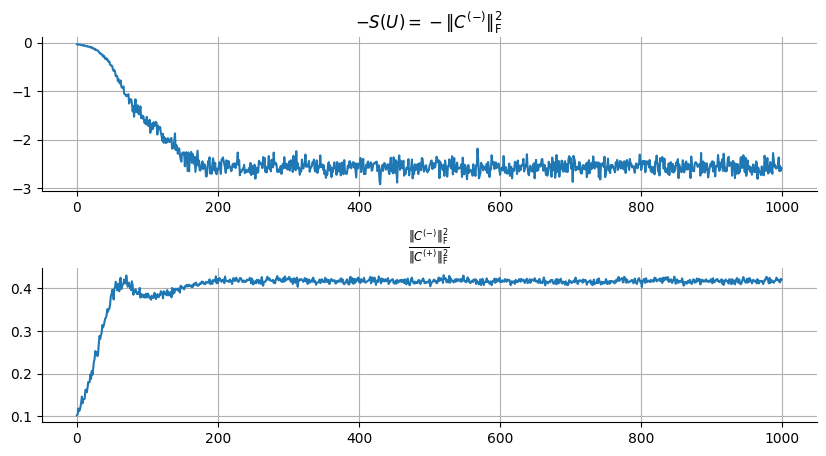

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)


In [23]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/optimized_U_linear_SCA/optimized_U_16052024_123710.npy')
s = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/optimized_U_linear_SCA/optimized_s_16052024_123710.npy')

In [17]:
#U = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/optimized_U_linear_SCA/QQ_revised/U_churchland_QQ.npy")
U = optimized_params

0.39470422


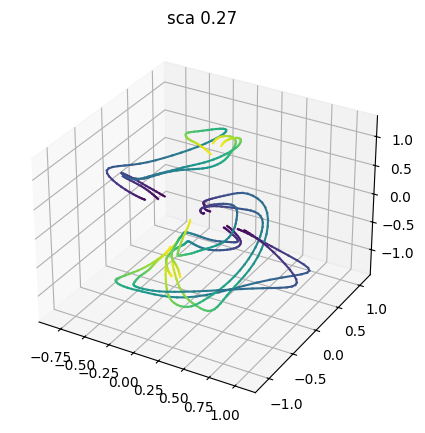

In [18]:
#X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/churchland.npy') 
#X = jnp.array(X) 

# s_normalized = jnp.sqrt(X.shape[1]) * (s ** 2) / jnp.linalg.norm(s ** 2)
# X_scaled = s_normalized[None, :, None] *  X

#plt.plot(s_normalized)

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr[:,:], X[:10,:,:])         #(K,d,T) 

plot_3D(Y[:,:,:])
plt.title(f"sca {var_explained(X[:10], U_qr):.2f}")

#Set the axis limits
# min = -7
# max = 7
# ax.set_xlim([min, max])
# ax.set_ylim([min, max])
# ax.set_zlim([min, max])
print(np.mean(compute_S(Y)))

In [ ]:
def make_frame(angle):
    ax.view_init(angle, 30)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0,360, 2) 
frames = [make_frame(angle) for angle in angles]

#gif_path = date_time_str + "_trajectories_rotation.gif"
gif_path = "trajectories_rotation.gif"
imageio.mimsave(gif_path, frames, fps=20)


gif_path

In [15]:
fig = go.Figure()
num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]
    y = Y[i, 1, :]
    z = Y[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='X', range=[min, max]),
#         yaxis=dict(title='Y', range=[-0.5, 0.5]),
#         zaxis=dict(title='Z', range=[min, max])
#     )
# )

fig.show()

ENDS HERE 